# Acute Lymphoblastic Leukemia 

Leukemia is a type of cancer that affects the blood and bone marrow. This causes the body to producee too much adnormal white blood cells. These cells cannot fight infections and prevent bone marrow from poducing healthy red blood cells and platelets. 

Acute lymphoblastic leukemia is one of the most common type of childhood cancers, totaling up to 25% of pediatric cancers. Identifying leukemic cells from normal cells nuder the microscope can be challenging becuase of the morphological similarities.


**Task:** Using image classification model, identify normal cells from cancer cells. 

**Data Source:** https://www.kaggle.com/datasets/andrewmvd/leukemia-classification

---

#### ``Objectives``
1. Implement a Convolutional Nural Network (CNN) model to detect leukemic cells from microscopic cell images.
2. Improve generalization performance and reduce overfitting using image transformation and data augmentation techniques.

#### ``Motivation``

Leukemia is a type of cancer that affects the blood and bone marrow, often characterized by abnormal white blood cell production. Early and accurate detection of leukemia through microscopic examination of blood samples is critical for timely treatment and improved patient outcomes. Automating this process with machine learning models can enhance diagnostic efficiency and accessibility, benefiting patients and healthcare systems.

#### ``Data``

https://www.kaggle.com/datasets/andrewmvd/leukemia-classification

---
### Step 1: Import libraries

In [ ]:
#using an LLM to assist with coding

# Standard Libraries
import pandas as pd
import numpy as np
import random
import os

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras import models, layers

# Sklearn
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

# Set random seed for reproducibility
random.seed(2)
%matplotlib inline

# Paths
TRAIN_IMAGE_PATH = 'C:/Users/erica/OneDrive/Desktop/Berkeley/207/leukemia_classification/C-NMC_Leukemia/training_data/'
VALIDATION_IMAGE_PATH = 'C:/Users/erica/OneDrive/Desktop/Berkeley/207/leukemia_classification/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data/'
LABEL_PATH = 'C:/Users/erica/OneDrive/Desktop/Berkeley/207/leukemia_classification/C-NMC_Leukemia/validation_data/'
TEST_IMAGE_PATH = 'C:/Users/erica/OneDrive/Desktop/Berkeley/207/leukemia_classification/C-NMC_Leukemia/testing_data/C-NMC_test_final_phase_data/'

# --- Loading Training Data ---
train_images = []
train_labels = []

# Iterate through folds and subfolders in training data
for fold in ['fold_0', 'fold_1', 'fold_2']:
    for category in ['all', 'hem']:
        folder_path = os.path.join(TRAIN_IMAGE_PATH, fold, category)
        label = 1 if category == 'all' else 0  # 1 for cancer (all), 0 for healthy (hem)
        
        # Load images from the folder
        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)
            img = load_img(img_path, target_size=(224, 224))  # Resize images to 224x224
            train_images.append(img_to_array(img) / 255.0)  # Normalize pixel values
            train_labels.append(label)

# Convert to numpy arrays
train_images = np.array(train_images)
train_labels = np.array(train_labels)
print(f"Loaded {len(train_images)} training images.")
print(f"Sample training labels: {train_labels[:10]}")  # Print first 10 labels

# --- Loading Validation Data ---
validation_images = []
validation_labels = []

# Load validation labels from CSV
labels = pd.read_csv(LABEL_PATH + 'C-NMC_test_prelim_phase_data_labels.csv')
labels['file_path'] = labels['new_names'].apply(lambda x: os.path.join(VALIDATION_IMAGE_PATH, x))

# Load images and labels
for _, row in labels.iterrows():
    img_path = row['file_path']
    label = row['labels']
    img = load_img(img_path, target_size=(224, 224))  # Resize images
    validation_images.append(img_to_array(img) / 255.0)  # Normalize pixel values
    validation_labels.append(label)

# Convert to numpy arrays
validation_images = np.array(validation_images)
validation_labels = np.array(validation_labels)
print(f"Loaded {len(validation_images)} validation images.")
print(f"Sample validation labels: {validation_labels[:10]}")  # Print first 10 labels

# --- Loading Test Data ---
test_images = []

for idx, img in enumerate(os.listdir(TEST_IMAGE_PATH)):
    img_path = os.path.join(TEST_IMAGE_PATH, img)
    img = load_img(img_path, target_size=(224, 224))  # Resize images
    test_images.append(img_to_array(img) / 255.0)  # Normalize pixel values

test_images = np.array(test_images)
print(f"Loaded {len(test_images)} test images.")
# Note: Test labels may not be available if ground truth is hidden.

# --- Summary of Dataset ---
print(f"Training set: {train_images.shape}, Labels: {train_labels.shape}")
print(f"Validation set: {validation_images.shape}, Labels: {validation_labels.shape}")
print(f"Test set: {test_images.shape}")


Loaded 10661 training images.
Sample training labels: [1 1 1 1 1 1 1 1 1 1]
Loaded 1867 validation images.
Sample validation labels: [1 1 1 0 1 1 0 0 1 1]
Loaded 2586 test images.
Training set: (10661, 224, 224, 3), Labels: (10661,)
Validation set: (1867, 224, 224, 3), Labels: (1867,)
Test set: (2586, 224, 224, 3)


---
### Step 3: Exploratory Data Analysis (EDA)

Plot a histogram to visualize the distribution of the two classes in the leukemia dataset: 'Healthy (hem)' and 'Cancer (all)'. The bar plot displays the total number of samples for each class across the combined training and validation datasets.

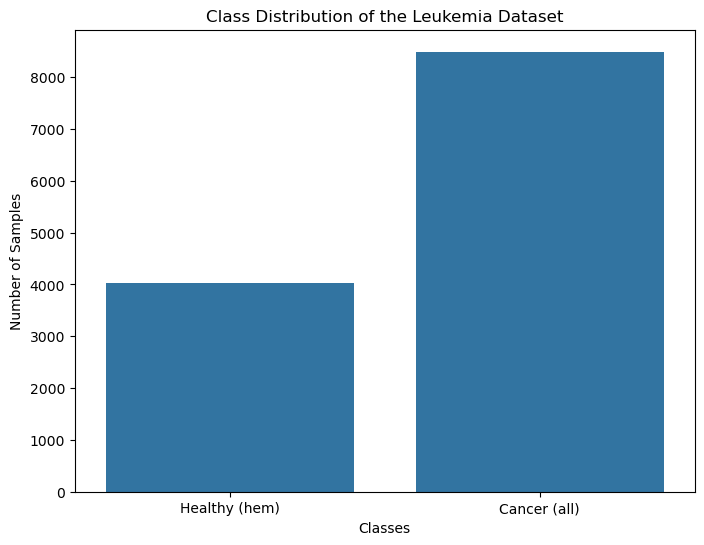

In [ ]:
#using an LLM to assist with coding

# Combine labels from all datasets for visualization
combined_labels = np.concatenate([train_labels, validation_labels])

# Count the occurrences of each class
class_counts = np.bincount(combined_labels)
class_names = ['Healthy (hem)', 'Cancer (all)']

# Plot the histogram
plt.figure(figsize=(8, 6))  # Define the figure size only once
sns.barplot(x=class_names, y=class_counts)
plt.title('Class Distribution of the Leukemia Dataset')
plt.ylabel('Number of Samples')
plt.xlabel('Classes')
plt.show()



Comment on class balance: 
The classes are not too balanced with roughly 2x more cancer (all) samples compared to healthy (hem). It's not realistic that it would reflect the population as a whole, although could reflect the population sent for testing.

#### <span style="color:chocolate"> Exercise 3 (10 points) </span>

Print 50 images from the data. What can you say about the size, focus/orientation of these images?

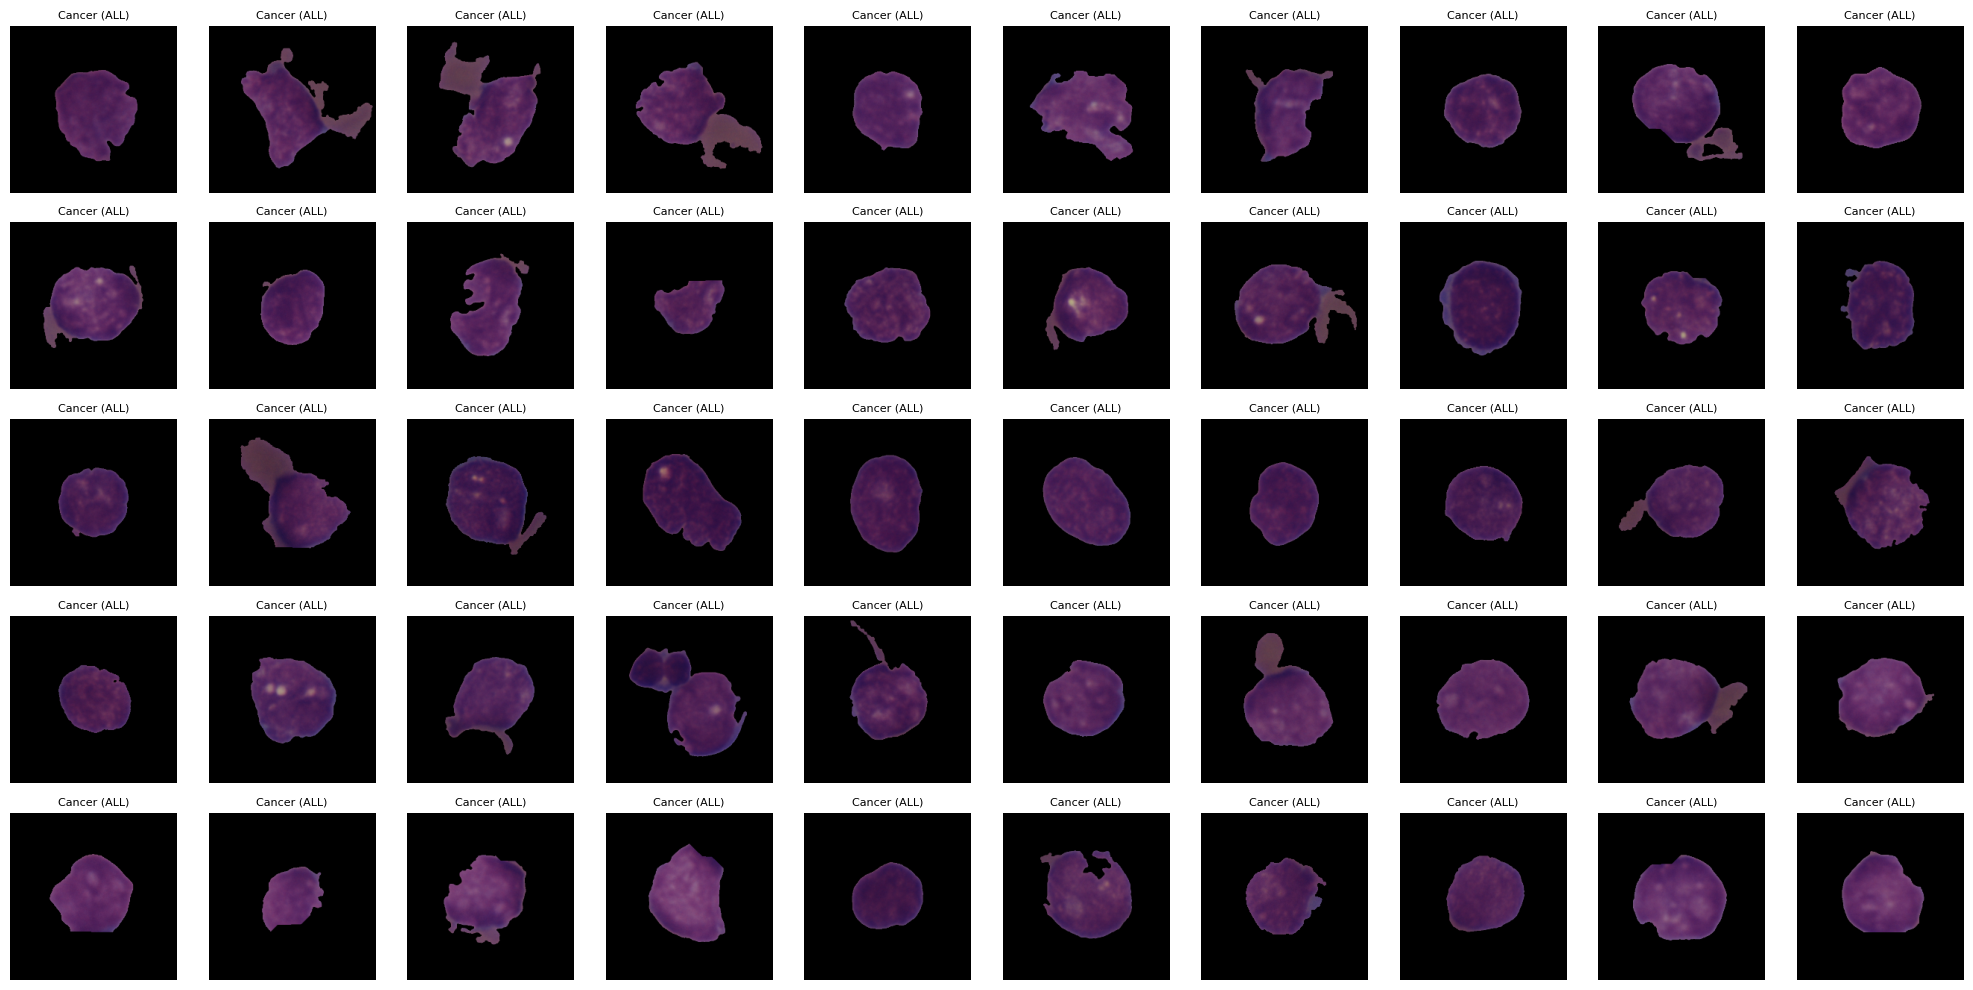

In [ ]:
#using an LLM to assist with coding

import matplotlib.pyplot as plt

# Number of images to display
num_images = 50

# Create a figure to display the images
plt.figure(figsize=(20, 10))  # Adjust the figure size for better visibility

for i in range(num_images):
    # Select an image and its corresponding label
    image = train_images[i]
    label = 'Cancer (ALL)' if train_labels[i] == 1 else 'Healthy (HEM)'
    
    # Add a subplot in a 5x10 grid
    plt.subplot(5, 10, i+1)  # 5 rows, 10 columns
    plt.imshow(image.astype('float32'))
    plt.title(label, fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()



Comment on the size, focus/orientation of the 50 images:
Size: the images all seem to be the same pixels
Focus: The images have clear cell boundaries and good focus with some boundary abnormalities visible.  The orientation is difficult to assess, but the results still may be better with data augmentation to help.

---
### Step 4: Data preprocessing

In [13]:
#using an LLM to assist with coding

# Collect IDs from training data
healthy_ids = set()
cancer_ids = set()

for fold in ['fold_0', 'fold_1', 'fold_2']:
    for category in ['all', 'hem']:
        folder_path = os.path.join(TRAIN_IMAGE_PATH, fold, category)
        for img_name in os.listdir(folder_path):
            img_id = img_name.split('_')[1]  # Extract ID from filename
            if category == 'all':
                cancer_ids.add(img_id)
            elif category == 'hem':
                healthy_ids.add(img_id)

# Balance the classes
np.random.seed(1234)
sample_size = min(len(healthy_ids), len(cancer_ids))
healthy_balanced_ids = list(np.random.choice(list(healthy_ids), size=sample_size, replace=False))
cancer_balanced_ids = list(np.random.choice(list(cancer_ids), size=sample_size, replace=False))

# Initialize as lists before appending
train_images = []
train_labels = []

# Preprocess balanced dataset
for fold in ['fold_0', 'fold_1', 'fold_2']:
    for category in ['all', 'hem']:
        folder_path = os.path.join(TRAIN_IMAGE_PATH, fold, category)
        for img_name in os.listdir(folder_path):
            img_id = img_name.split('_')[1]  # Extract ID from filename
            
            if img_id in healthy_balanced_ids:
                label = 0  # Healthy
            elif img_id in cancer_balanced_ids:
                label = 1  # Cancer
            else:
                continue

            img_path = os.path.join(folder_path, img_name)
            img = load_img(img_path, target_size=(224, 224))  # Resize to 224x224
            train_images.append(img_to_array(img) / 255.0)  # Normalize pixel values
            train_labels.append(label)

# Convert to numpy arrays after all data is appended
train_images = np.array(train_images)
train_labels = np.array(train_labels)
print(f"Loaded {len(train_images)} balanced training images.")
print(f"Sample training labels: {train_labels[:10]}")

# --- Loading Validation Data ---
validation_images = []
validation_labels = []

# Load validation labels from CSV
labels = pd.read_csv(LABEL_PATH + 'C-NMC_test_prelim_phase_data_labels.csv')
labels['file_path'] = labels['new_names'].apply(lambda x: os.path.join(VALIDATION_IMAGE_PATH, x))

# Load images and labels
for _, row in labels.iterrows():
    img_path = row['file_path']
    label = row['labels']
    img = load_img(img_path, target_size=(224, 224))  # Resize images
    validation_images.append(img_to_array(img) / 255.0)  # Normalize pixel values
    validation_labels.append(label)

# Convert to numpy arrays
validation_images = np.array(validation_images)
validation_labels = np.array(validation_labels)
print(f"Loaded {len(validation_images)} validation images.")
print(f"Sample validation labels: {validation_labels[:10]}")

# --- Loading Test Data ---
test_images = []

for img_name in os.listdir(TEST_IMAGE_PATH):
    img_path = os.path.join(TEST_IMAGE_PATH, img_name)
    img = load_img(img_path, target_size=(224, 224))  # Resize images
    test_images.append(img_to_array(img) / 255.0)  # Normalize pixel values

test_images = np.array(test_images)
print(f"Loaded {len(test_images)} test images.")

# --- Summary of Dataset ---
print(f"Training set: {train_images.shape}, Labels: {train_labels.shape}")
print(f"Validation set: {validation_images.shape}, Labels: {validation_labels.shape}")
print(f"Test set: {test_images.shape}")




Loaded 7427 balanced training images.
Sample training labels: [1 1 1 1 1 1 1 1 1 1]
Loaded 1867 validation images.
Sample validation labels: [1 1 1 0 1 1 0 0 1 1]
Loaded 2586 test images.
Training set: (7427, 224, 224, 3), Labels: (7427,)
Validation set: (1867, 224, 224, 3), Labels: (1867,)
Test set: (2586, 224, 224, 3)


In [ ]:
#using an LLM to assist with coding

def preprocess_data(TRAIN_IMAGE_PATH, healthy_ids, cancer_ids):
    """ Generate lists of images and labels based on the provided IDs for healthy and cancer categories. """

    y_mini = []
    images_mini = []

    # Iterate over the folds
    for fold in ['fold_0', 'fold_1', 'fold_2']:
        for category in ['all', 'hem']:
            category_path = os.path.join(TRAIN_IMAGE_PATH, fold, category)
            
            # Debugging: Print the category path and filenames
            print(f"Processing folder: {category_path}")
            print(f"First few files in folder: {os.listdir(category_path)[:5]}")

            # Iterate over all images in the category folder
            for img_name in os.listdir(category_path):
                # Extract the numeric ID from the filename
                img_id = img_name.split('_')[1]  # Second part of the filename

                # Debugging: Check if the ID matches
                if img_id in healthy_ids or img_id in cancer_ids:
                    print(f"Matching ID found: {img_id} -> {img_name}")

                # Assign labels based on the IDs
                if img_id in healthy_ids:
                    y_mini.append(0)  # Label 0 for healthy
                elif img_id in cancer_ids:
                    y_mini.append(1)  # Label 1 for cancer
                else:
                    continue

                # Load the image and preprocess it
                img = load_img(
                    os.path.join(category_path, img_name),
                    target_size=(224, 224)  # Resize images
                )
                img = img_to_array(img) / 255.0  # Convert to array and normalize
                images_mini.append(img)

    # Check if any images were loaded
    if not images_mini:
        raise ValueError("No valid images were loaded. Check if IDs match filenames in TRAIN_IMAGE_PATH.")

    # Convert lists to numpy arrays
    images_mini = np.stack(images_mini)
    y_mini = np.array(y_mini).flatten()
    
    return images_mini, y_mini

# Preprocess the balanced dataset
images_mini, y_mini = preprocess_data(TRAIN_IMAGE_PATH, healthy_balanced_ids, cancer_balanced_ids)

# Output shapes
print(f"images_mini shape: {images_mini.shape}")
print(f"y_mini shape: {y_mini.shape}")

# Check the class distribution
unique, counts = np.unique(y_mini, return_counts=True)
print(f"Balanced class counts: {dict(zip(unique, counts))}")







Processing folder: C:/Users/erica/OneDrive/Desktop/Berkeley/207/leukemia_classification/C-NMC_Leukemia/training_data/fold_0\all
First few files in folder: ['UID_11_10_1_all.bmp', 'UID_11_11_1_all.bmp', 'UID_11_11_2_all.bmp', 'UID_11_11_3_all.bmp', 'UID_11_12_1_all.bmp']
Matching ID found: 15 -> UID_15_11_1_all.bmp
Matching ID found: 15 -> UID_15_12_1_all.bmp
Matching ID found: 15 -> UID_15_13_1_all.bmp
Matching ID found: 15 -> UID_15_14_1_all.bmp
Matching ID found: 15 -> UID_15_15_1_all.bmp
Matching ID found: 15 -> UID_15_15_2_all.bmp
Matching ID found: 15 -> UID_15_16_1_all.bmp
Matching ID found: 15 -> UID_15_16_2_all.bmp
Matching ID found: 15 -> UID_15_16_3_all.bmp
Matching ID found: 15 -> UID_15_16_4_all.bmp
Matching ID found: 15 -> UID_15_17_1_all.bmp
Matching ID found: 15 -> UID_15_17_2_all.bmp
Matching ID found: 15 -> UID_15_18_1_all.bmp
Matching ID found: 15 -> UID_15_18_2_all.bmp
Matching ID found: 15 -> UID_15_18_3_all.bmp
Matching ID found: 15 -> UID_15_19_1_all.bmp
Matching 

Prepare training, validation, and test datasets with lazy loading and on-the-fly transformations for the leukemia classification task. The goal of the function is to ensure the model has balanced data for train, validation, and test, while leveraging augmentation to improve generalization.  Lazy loading is utilized to help process the large dataset by processing on demand.

Data Splitting:
Shuffle images and labels before splitting to ensure randomness.
Divide the dataset into training, validation, and test sets using a (0.6, 0.2, 0.2) split ratio.

Lazy Loading:
Convert data into TensorFlow datasets (tf.data.Dataset) for efficient processing.
Batch and prefetch the data to optimize pipeline performance during model training.

Data Augmentation:
Augment the training data with horizontal flips using TensorFlow's tf.image module to improve generalization and prevent overfitting.
Note: Augmentation is applied only to the training dataset.

Data Preparation:
Rescale pixel values in all datasets to the range [0, 1] by dividing by 255.0.
Use batching and prefetching to speed up data loading and ensure efficient utilization of GPU/CPU during training.

In [6]:
#using an llm to assist with coding

import tensorflow as tf

def preprocess_data_with_lazy_loading(images, labels, splits=(0.6, 0.2, 0.2), batch_size=32):
    """
    Split data into train, validation, and test sets; apply on-the-fly transformations and lazy loading.

    Params:
    -------
    images (np.ndarray): Images of shape (N, H, W, C).
    labels (np.ndarray): Labels of shape (N,).
    splits (tuple): Proportions for train, validation, and test sets (must sum to 1).
    batch_size (int): Batch size for data generators.

    Returns:
    --------
    train_dataset (tf.data.Dataset): Dataset for training (with augmentation).
    val_dataset (tf.data.Dataset): Dataset for validation.
    test_dataset (tf.data.Dataset): Dataset for testing.
    """
    # Convert inputs to TensorFlow tensors
    images = tf.convert_to_tensor(images, dtype=tf.float32)
    labels = tf.convert_to_tensor(labels, dtype=tf.int32)

    # Shuffle data indices and split into train, validation, and test
    indices = tf.random.shuffle(tf.range(len(images)))
    train_size = int(splits[0] * len(images))
    val_size = int(splits[1] * len(images))

    train_indices = indices[:train_size]
    val_indices = indices[train_size:train_size + val_size]
    test_indices = indices[train_size + val_size:]

    # Split images and labels using indices
    X_train, y_train = tf.gather(images, train_indices), tf.gather(labels, train_indices)
    X_val, y_val = tf.gather(images, val_indices), tf.gather(labels, val_indices)
    X_test, y_test = tf.gather(images, test_indices), tf.gather(labels, test_indices)

    # Create datasets
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
    test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

    # Apply augmentation to training dataset
    train_dataset = train_dataset.map(
        lambda x, y: (tf.image.flip_left_right(x), y)
    )

    # Shuffle and batch datasets
    train_dataset = train_dataset.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return train_dataset, val_dataset, test_dataset

# Call the function
split = (0.6, 0.2, 0.2)
batch_size = 32
train_dataset, val_dataset, test_dataset = preprocess_data_with_lazy_loading(
    images_mini,
    y_mini,
    splits=split,
    batch_size=batch_size
)

# Check the dataset output
for batch_images, batch_labels in train_dataset.take(1):
    print(f"Batch images shape: {batch_images.shape}")
    print(f"Batch labels shape: {batch_labels.shape}")


Batch images shape: (32, 224, 224, 3)
Batch labels shape: (32,)


---
### Step 5: Modeling

The objective of this code is to build and train a Convolutional Neural Network (CNN) model to classify leukemia cell images into two categories: healthy (hem) and cancerous (all). This binary classification can assist in automating the process of distinguishing cancerous cells from healthy ones, thereby supporting early detection and diagnosis of leukemia.

The code implements a CNN classifier as follows:

1. The model is implemented using TensorFlow's Keras API.
2. The model accepts input images of size 224 x 224 x 3 (RGB format, three color channels).
3. The first layer is a convolutional layer with the following specifications::
    - filters = 12
    - kernel_size = (4 x 4)
    - strides = (1, 1)
    - padding = 'same'
    - data_format = 'channels_last'
    - name = 'conv_1'
    - activation = 'relu'
4. Max-pooling Layer: The convolutional layer is followed by a max-pooling layer with pool_size = (2,2). This reduces the spatial dimensions of the feature maps, thereby decreasing computational complexity while retaining key features.
5. Dropout Layer: The max-pooling layer is followed by a dropout layer with rate = 0.3 to prevent overfitting by randomly deactivating 30% of neurons during training. 
6. Flattening Layer: The feature maps are flattened into a 1D array to prepare the data for the fully connected layer.
7. Classification Layer: The final layer is a dense layer with one neuron and a sigmoid activation function which outputs the probability of the image belonging to the cancerous category.
8. Model Compilation: The model is compiled as follows:
    - Optimizer: Adam optimizer with a learning rate of 0.1
    - Loss function: Binary crossentropy for binary classification
    - Metrc: Accuracy
    - Training: The model is trained for up to 20 epochs using the train_dataset and validated on the val_dataset.  An eary stopping mechanism is utilized to halt training when the validation loss stops improving for 5 consecutive epochs.
9. A plot is generated of training and validation loss over epochs to visualize the learning process.
10. Evaluation: The model's accuracy and loss are evaluated on both the training and validation data sets providing important insight into the model's performance.  

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                 │ (None, 224, 224, 12)   │           588 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 12)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 12)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │       150,529 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 151,117 (590.30 KB)

 Trainable params: 151,117 (590.30 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - accuracy: 0.5240 - loss: 18.1597 - val_accuracy: 0.5596 - val_loss: 0.6881
Epoch 2/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - accuracy: 0.5168 - loss: 0.6931 - val_accuracy: 0.5596 - val_loss: 0.6861
Epoch 3/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - accuracy: 0.5315 - loss: 0.6926 - val_accuracy: 0.5596 - val_loss: 0.6918
Epoch 4/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.5381 - loss: 0.6914 - val_accuracy: 0.5596 - val_loss: 0.6917
Epoch 5/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.5386 - loss: 0.6916 - val_accuracy: 0.5596 - val_loss: 0.6861
Epoch 6/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.5108 - loss: 0.6950 - val_accuracy: 0.5596 - val_loss: 0.6891
Epoch 7/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.5273 - loss: 0.6925 - val_accuracy: 0.5596 - val_loss: 0.6873
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 2.


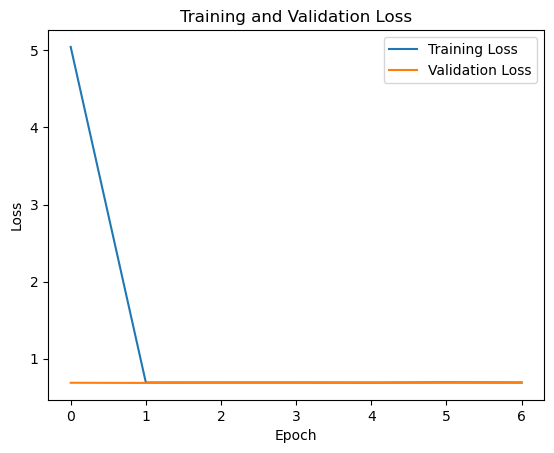

Training Accuracy: 0.5424
Validation Accuracy: 0.5596


In [ ]:
#using an llm to assist with coding

import tensorflow as tf
import matplotlib.pyplot as plt

# Define early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    verbose=1,
    mode='min', 
    restore_best_weights=True
)

# Set random seeds for reproducibility
tf.random.set_seed(1234)
np.random.seed(1234)

# Initialize the model
model_tf = tf.keras.Sequential()

# Add convolutional layer
model_tf.add(tf.keras.layers.Conv2D(
    filters=12,
    kernel_size=(4, 4),
    strides=(1, 1),
    padding='same',
    data_format='channels_last',
    activation='relu',
    name='conv_1'
))

# Add max pooling layer
model_tf.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Add dropout layer
model_tf.add(tf.keras.layers.Dropout(rate=0.3))

# Add flattening layer
model_tf.add(tf.keras.layers.Flatten())

# Add classification layer
model_tf.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Build and compile the model
model_tf.build(input_shape=(None, 224, 224, 3))
model_tf.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
                 loss=tf.keras.losses.BinaryCrossentropy(),
                 metrics=['accuracy'])

# Print the model summary
model_tf.summary()

# Train the model
history = model_tf.fit(
    train_dataset,  # Assuming train_dataset is from lazy loading
    validation_data=val_dataset,  # Assuming val_dataset is from lazy loading
    epochs=20,
    callbacks=[early_stopping]
)

# Plot loss curves
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Evaluate the model on training and validation data
train_loss, train_accuracy = model_tf.evaluate(train_dataset, verbose=0)
val_loss, val_accuracy = model_tf.evaluate(val_dataset, verbose=0)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")



How many parameters does *model_tf* have? 151,117 parameters

Comment on *model_tf* accuracy on training vs. validation data: 
The training accuracy is .5424 verses the validation accuracy of .5596.  This is close to just random guessing and not great performance.  The values are similar vetween accuracy and validation, which could suggest underfitting.  

Build and train a Convolutional Neural Network (CNN) to classify leukemia images into two categories: 'Healthy (hem)' and 'Cancer (all)'. This binary classification task aims to identify cancerous samples for further medical evaluation.

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_rotation_1               │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_1 (RandomZoom)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_brightness               │ (None, 224, 224, 3)    │             0 │
│ (RandomBrightness)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip (RandomFlip)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,783,873 (98.36 MB)

 Trainable params: 25,783,873 (98.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 65s 436ms/step - accuracy: 0.5248 - loss: 2.8565 - val_accuracy: 0.5596 - val_loss: 0.6735
Epoch 2/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 122s 723ms/step - accuracy: 0.5466 - loss: 0.7574 - val_accuracy: 0.5596 - val_loss: 0.6904
Epoch 3/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 63s 448ms/step - accuracy: 0.5420 - loss: 0.7584 - val_accuracy: 0.5596 - val_loss: 0.6486
Epoch 4/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 92s 660ms/step - accuracy: 0.5368 - loss: 0.7576 - val_accuracy: 0.5596 - val_loss: 0.6111
Epoch 5/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 64s 459ms/step - accuracy: 0.5371 - loss: 0.7553 - val_accuracy: 0.7576 - val_loss: 0.5645
Epoch 6/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 88s 627ms/step - accuracy: 0.5476 - loss: 0.7550 - val_accuracy: 0.6761 - val_loss: 0.5812
Epoch 7/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 70s 498ms/step - accuracy: 0.5377 - loss: 0.7541 - val_accuracy: 0.6586 - val_loss: 0.5910
Epoch 8/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 80s 574ms/step - accuracy: 0.5385 - loss: 

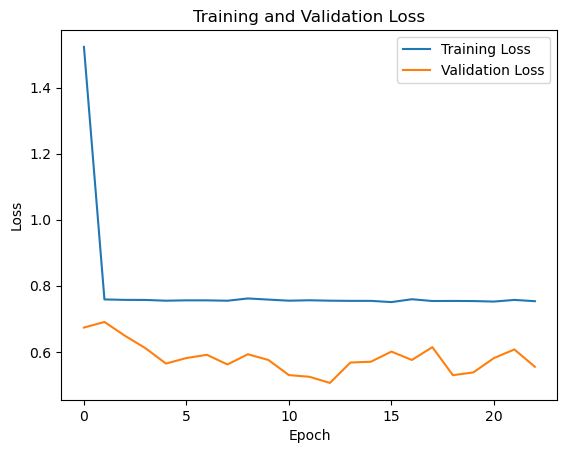

Training Accuracy: 0.7830
Validation Accuracy: 0.7778


In [11]:
#using LLM to assist with coding

import tensorflow as tf
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
tf.random.set_seed(1234)
np.random.seed(1234)

# Define class weights to address class imbalance
class_weight = {0: 1.0, 1: 1.2}  # Adjust based on class proportions

# Initialize the fine-tuned model
model_tf = tf.keras.Sequential()

# Data augmentation layers
model_tf.add(tf.keras.layers.RandomRotation(factor=0.1, input_shape=(224, 224, 3)))
model_tf.add(tf.keras.layers.RandomZoom(height_factor=0.1, width_factor=0.1))
model_tf.add(tf.keras.layers.RandomBrightness(factor=0.2))
model_tf.add(tf.keras.layers.RandomFlip(mode="horizontal"))

# First convolutional block
model_tf.add(tf.keras.layers.Conv2D(
    filters=32,  # Increased filters
    kernel_size=(3, 3),
    strides=(1, 1),
    padding='same',
    activation='relu',
    name='conv_1'
))
model_tf.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Second convolutional block
model_tf.add(tf.keras.layers.Conv2D(
    filters=64,  # Increased filters
    kernel_size=(3, 3),
    strides=(1, 1),
    padding='same',
    activation='relu',
    name='conv_2'
))
model_tf.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Third convolutional block
model_tf.add(tf.keras.layers.Conv2D(
    filters=128,  # Further increased filters
    kernel_size=(3, 3),
    strides=(1, 1),
    padding='same',
    activation='relu',
    name='conv_3'
))
model_tf.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Dropout layer to prevent overfitting
model_tf.add(tf.keras.layers.Dropout(rate=0.5))

# Flatten layer
model_tf.add(tf.keras.layers.Flatten())

# Dense hidden layer
model_tf.add(tf.keras.layers.Dense(256, activation='relu', name='dense_1'))
model_tf.add(tf.keras.layers.Dropout(rate=0.4))  # Increased dropout

# Classification layer
model_tf.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Build and compile the model with an adjusted learning rate
model_tf.build(input_shape=(None, 224, 224, 3))
model_tf.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Higher learning rate
                 loss=tf.keras.losses.BinaryCrossentropy(),
                 metrics=['accuracy'])

# Print the model summary
model_tf.summary()

# Define early stopping with increased patience
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=10,  # Allow more training epochs before stopping
    restore_best_weights=True
)

# Train the model with class weights
history = model_tf.fit(
    train_dataset,  # Lazy-loaded dataset
    validation_data=val_dataset,  # Lazy-loaded dataset
    epochs=50,
    class_weight=class_weight,  # Address class imbalance
    callbacks=[early_stopping]
)

# Plot loss curves
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Evaluate the model on training and validation datasets
train_loss, train_accuracy = model_tf.evaluate(train_dataset, verbose=0)
val_loss, val_accuracy = model_tf.evaluate(val_dataset, verbose=0)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")



How many parameters does your fine-tuned model have? Total parameters: 25,783,873

Comment on accuracy of the fine-tuned model on training vs. validation performance. Is there an improvement over the non-fine-tuned version? 
This now fine-tuned model shows a training accuracy of 78.3% vs. validation accuracy of 77.78%. This is an improvement over the non-fine-tuned version, which had a validation accuracy around 55.96%, the generalization is also improved.

---
### Step 6: Evaluation

Use test data to evaluate the performance (accuracy) of your fine-tuned model on unseen data. Does your model generalize well?

In [12]:
#using an LLM to assist with coding

# Evaluate the fine-tuned model on the test dataset
test_loss, test_accuracy = model_tf.evaluate(test_dataset, verbose=0)

# Print the test accuracy
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Check if the model generalizes well
if test_accuracy > val_accuracy - 0.05:  # Example: Allow a 5% drop from validation accuracy
    print("The model generalizes well to unseen data.")
else:
    print("The model does not generalize well. Consider further fine-tuning or regularization.")


Test Loss: 0.5149
Test Accuracy: 0.7826
The model generalizes well to unseen data.


Does your model generalize well? 
Yes, the model seems to generalize well with a test accuracy of 78.26%.  It does not seem to be overfitting, which is good.